# PCA Analysis

Purpose: Exploring the effectiveness of PCA for compressing patient scans. A compression technique is required, as the scans in their original size are too big and will take too long to be analyzed by neural networks.

In [292]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import glob
import re
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.decomposition import PCA
from time import time
import math

In [293]:
# constants

data = '/kaggle/dev/data-science-bowl-2017-data/'
stage1 = '/kaggle/dev/data-science-bowl-2017-data/stage1/'
sample_images = '/kaggle/dev/data-science-bowl-2017-data/sample_images/'
labels = '/kaggle/dev/data-science-bowl-2017-data/stage1_labels.csv'
stage1_processed = '/kaggle/dev/data-science-bowl-2017-data/stage1_processed/'
stage1_features = '/kaggle/dev/data-science-bowl-2017-data/stage1_features_mx/'
stage1_submission = '/kaggle/dev/data-science-bowl-2017-data/stage1_sample_submission.csv'
naive_submission = '/kaggle/dev/jovan/data-science-bowl-2017/data-science-bowl-2017/submissions/naive_submission.csv'

## Setup

In [294]:
sample_ids = []

for d in os.listdir(sample_images):
    sample_ids.append(d)
    print("Patient '{}' has {} scans".format(d, len(os.listdir(sample_images + d))))

print('----')
print('Total patients {} Total DCM files {}'.format(len(os.listdir(stage1)), 
                                                      len(glob.glob(stage1 + '*/*.dcm'))))

Patient '0c98fcb55e3f36d0c2b6507f62f4c5f1' has 180 scans
Patient '0d19f1c627df49eb223771c28548350e' has 183 scans
Patient '0c37613214faddf8701ca41e6d43f56e' has 164 scans
Patient '0d2fcf787026fece4e57be167d079383' has 126 scans
Patient '0a38e7597ca26f9374f8ea2770ba870d' has 110 scans
Patient '00cba091fa4ad62cc3200a657aeb957e' has 134 scans
Patient '0d941a3ad6c889ac451caf89c46cb92a' has 177 scans
Patient '0a0c32c9e08cc2ea76a71649de56be6d' has 133 scans
Patient '0c60f4b87afcb3e2dfa65abbbf3ef2f9' has 136 scans
Patient '0c9d8314f9c69840e25febabb1229fa4' has 221 scans
Patient '0ca943d821204ceb089510f836a367fd' has 147 scans
Patient '0b20184e0cd497028bdd155d9fb42dc9' has 196 scans
Patient '0c0de3749d4fe175b7a5098b060982a1' has 123 scans
Patient '0c59313f52304e25d5a7dcf9877633b1' has 244 scans
Patient '0bd0e3056cbf23a1cb7f0f0b18446068' has 280 scans
Patient '0de72529c30fe642bc60dcb75c87f6bd' has 113 scans
Patient '0ddeb08e9c97227853422bd71a2a695e' has 171 scans
Patient '0a099f2549429d29b32f34

In [338]:
print("Analysis will be done on:")
num_patients = 20 # number of patients to analyze
segmented_lungs_fill = []

for folder in glob.glob(stage1_processed + 'segment_lungs_fill_*'):
    m = re.match(r'segment_lungs_fill_([a-f0-9].*).npy', os.path.basename(folder))
    if(m.group(1) in sample_ids[0:num_patients]):
        x = np.load(stage1_processed + m.group(0))
        segmented_lungs_fill.append(x)
        print('Patient {}: array shape: {}'.format(m.group(1), x.shape))
        


Analysis will be done on:
Patient 0d06d764d3c07572074d468b4cff954f: array shape: (304, 424, 424)
Patient 0a38e7597ca26f9374f8ea2770ba870d: array shape: (275, 320, 320)
Patient 0c0de3749d4fe175b7a5098b060982a1: array shape: (308, 355, 355)
Patient 0c60f4b87afcb3e2dfa65abbbf3ef2f9: array shape: (272, 330, 330)
Patient 00cba091fa4ad62cc3200a657aeb957e: array shape: (335, 306, 306)
Patient 0ddeb08e9c97227853422bd71a2a695e: array shape: (342, 392, 392)
Patient 0c59313f52304e25d5a7dcf9877633b1: array shape: (305, 390, 390)
Patient 0c9d8314f9c69840e25febabb1229fa4: array shape: (398, 309, 309)
Patient 0d2fcf787026fece4e57be167d079383: array shape: (315, 310, 310)
Patient 0a0c32c9e08cc2ea76a71649de56be6d: array shape: (332, 340, 340)
Patient 0bd0e3056cbf23a1cb7f0f0b18446068: array shape: (350, 340, 340)
Patient 0d941a3ad6c889ac451caf89c46cb92a: array shape: (354, 259, 259)
Patient 0de72529c30fe642bc60dcb75c87f6bd: array shape: (282, 308, 308)
Patient 0acbebb8d463b4b9ca88cf38431aac69: array sha

Let's plot one patient (patient[0]) to see what the data looks like

In [182]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
#     ax.invert_zaxis()


    plt.show()

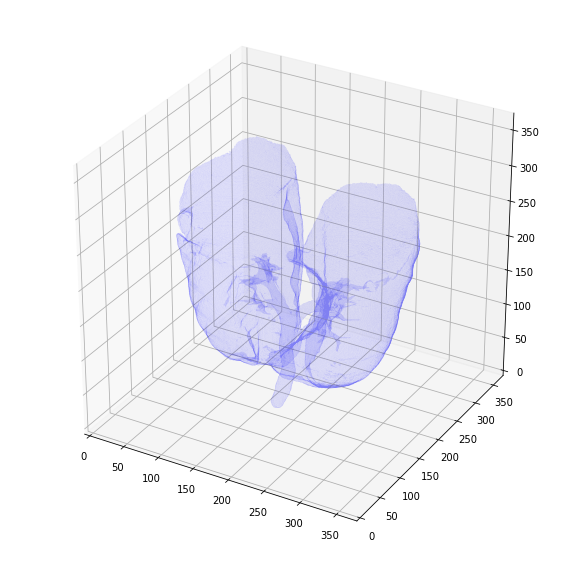

In [127]:
plot_3d(segmented_lungs_fill[0], 0)

## PCA

In [339]:
# Flatenning images to prep for PCA
segmented_lungs_fill_flatten = []
for i in range(0, num_patients):
    temp = segmented_lungs_fill[i].reshape(segmented_lungs_fill[i].shape[0], segmented_lungs_fill[i].shape[1]*
                                           segmented_lungs_fill[i].shape[2])
    segmented_lungs_fill_flatten.append(temp)
    print("Patient {}: original size {} -> flattened size: {}".format(i, segmented_lungs_fill[i].shape,
                                                                      segmented_lungs_fill_flatten[i].shape))

Patient 0: original size (304, 424, 424) -> flattened size: (304, 179776)
Patient 1: original size (275, 320, 320) -> flattened size: (275, 102400)
Patient 2: original size (308, 355, 355) -> flattened size: (308, 126025)
Patient 3: original size (272, 330, 330) -> flattened size: (272, 108900)
Patient 4: original size (335, 306, 306) -> flattened size: (335, 93636)
Patient 5: original size (342, 392, 392) -> flattened size: (342, 153664)
Patient 6: original size (305, 390, 390) -> flattened size: (305, 152100)
Patient 7: original size (398, 309, 309) -> flattened size: (398, 95481)
Patient 8: original size (315, 310, 310) -> flattened size: (315, 96100)
Patient 9: original size (332, 340, 340) -> flattened size: (332, 115600)
Patient 10: original size (350, 340, 340) -> flattened size: (350, 115600)
Patient 11: original size (354, 259, 259) -> flattened size: (354, 67081)
Patient 12: original size (282, 308, 308) -> flattened size: (282, 94864)
Patient 13: original size (365, 279, 279

In [405]:
def PCA_transform(patient_data, n_components):
    n_components = n_components
    h = int(math.sqrt(patient_data.shape[1]))
    pca = PCA(n_components=n_components, svd_solver='randomized',
              whiten=True).fit(patient_data)
    patient_data_pca = pca.transform(patient_data)
    eigenvectors = pca.components_.reshape((n_components, h, h))
    explained_variance_ratio = pca.explained_variance_ratio_
    return patient_data_pca, eigenvectors, explained_variance_ratio

In [406]:
def analyze_pca_varience(explained_variance_ratio, treshold):
    for i in explained_variance_ratio:
        if i <= treshold:
            return int(np.where(explained_variance_ratio <= (i))[0][0]) ## returning only the 0th element

In [435]:
n_components = 100
treshold = 0.001
patient_data_pca = []
eigenvectors = []
explained_variance_ratio = []
min_eigenvector= []
t0 = time()
for j in range(0, num_patients):
    t1 = time()
    w, x, y = PCA_transform(segmented_lungs_fill_flatten[j],n_components)
    z = analyze_pca_varience(y, treshold)
    patient_data_pca.append(w)
    eigenvectors.append(x)
    explained_variance_ratio.append(y)
    min_eigenvector.append(z)
    print("interation "+ str(j) + ", done in %0.3fs" % (time() - t1))

print("---")
print("total computation done in %0.3fs" % (time() - t0))

interation 0, done in 4.628s
interation 1, done in 2.569s
interation 2, done in 3.487s
interation 3, done in 3.218s
interation 4, done in 2.700s
interation 5, done in 4.210s
interation 6, done in 4.415s
interation 7, done in 3.006s
interation 8, done in 2.797s
interation 9, done in 2.972s
interation 10, done in 2.894s
interation 11, done in 1.941s
interation 12, done in 2.211s
interation 13, done in 2.492s
interation 14, done in 3.366s
interation 15, done in 3.635s
interation 16, done in 2.035s
interation 17, done in 3.459s
interation 18, done in 4.465s
interation 19, done in 3.888s
---
total computation done in 64.394s


Let's see what the eigenvectors look like for a one patient (patient[0])

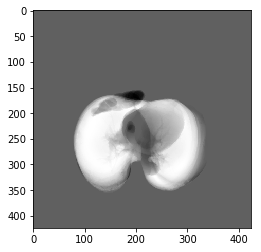

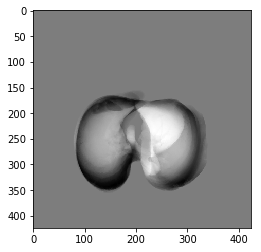

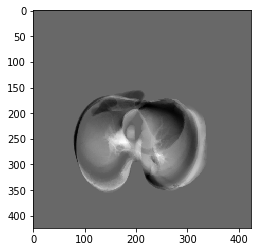

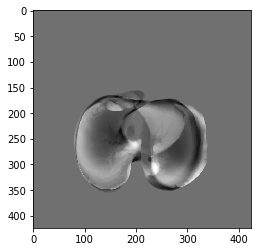

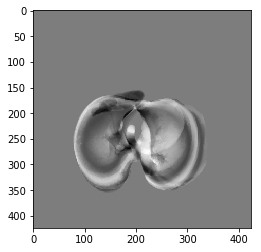

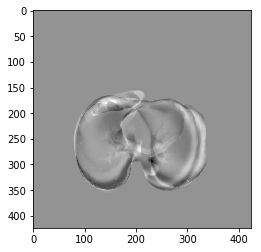

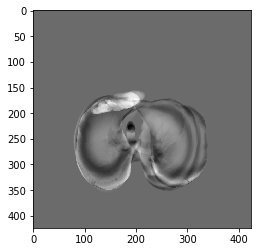

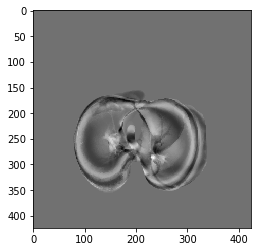

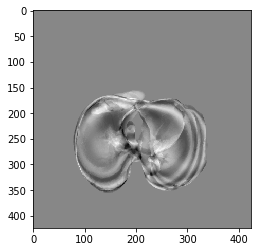

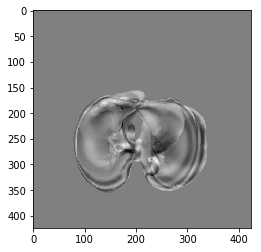

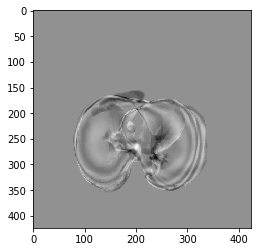

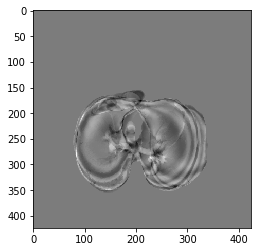

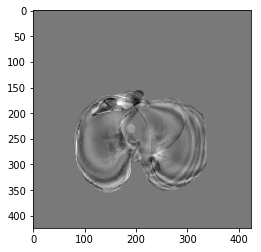

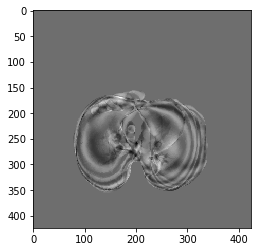

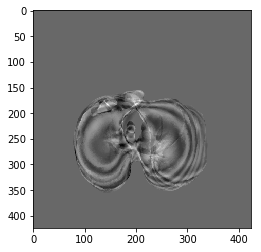

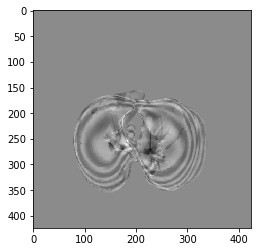

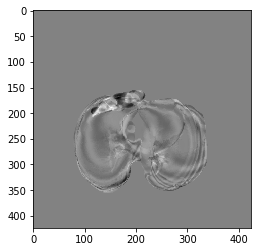

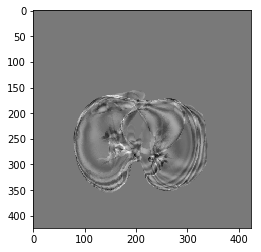

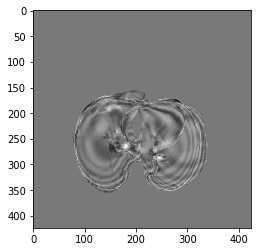

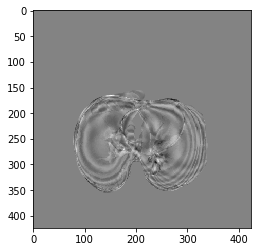

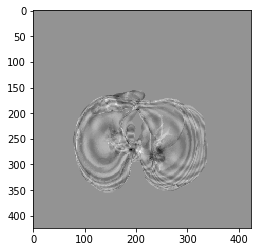

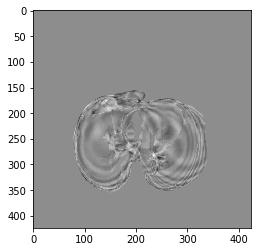

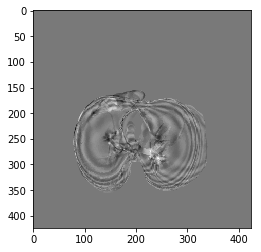

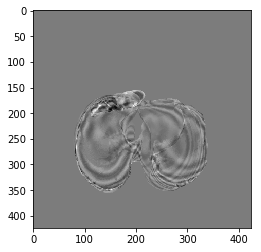

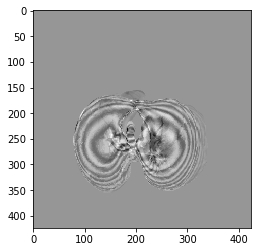

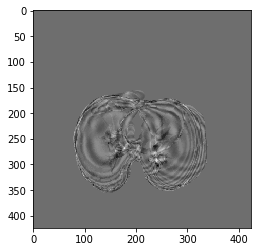

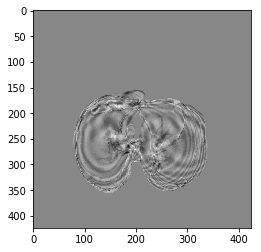

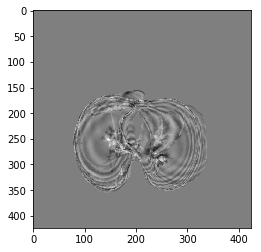

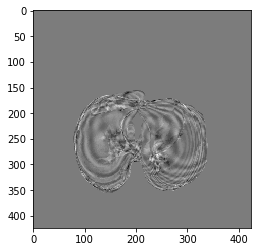

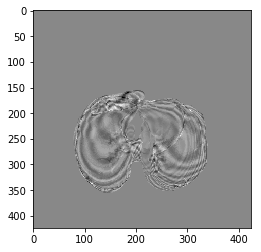

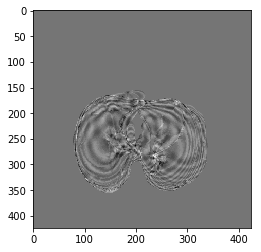

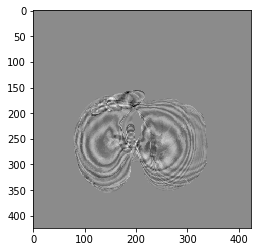

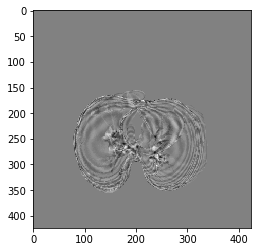

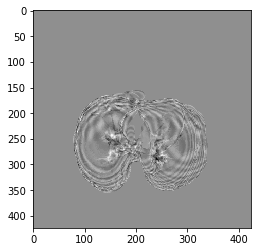

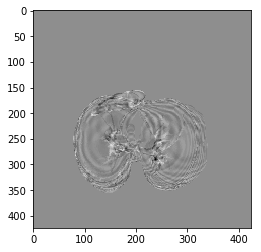

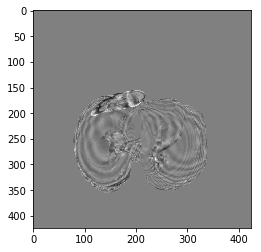

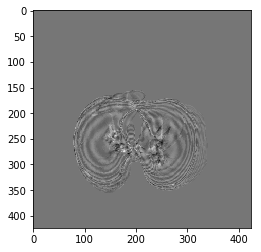

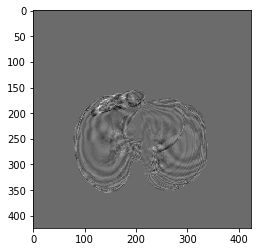

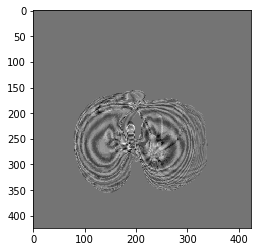

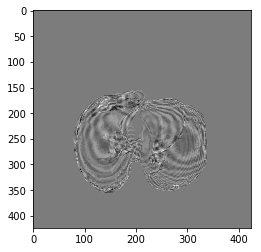

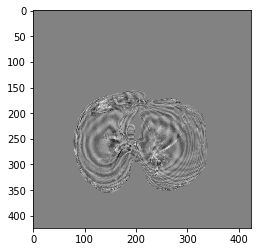

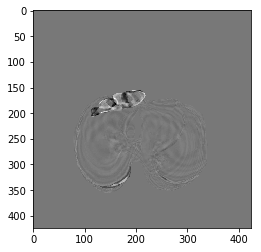

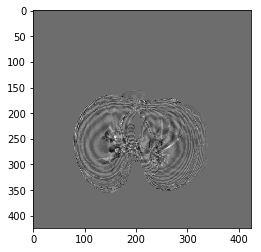

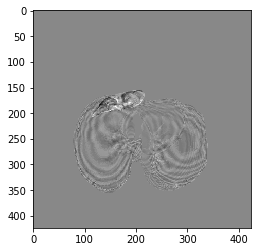

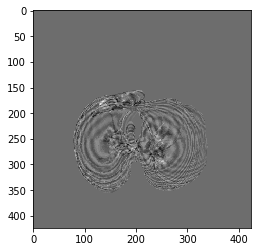

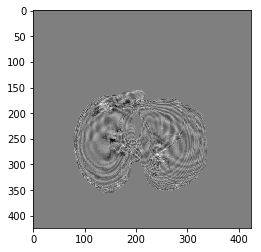

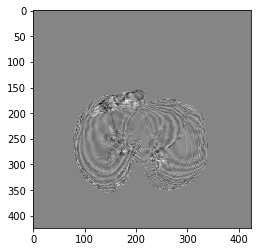

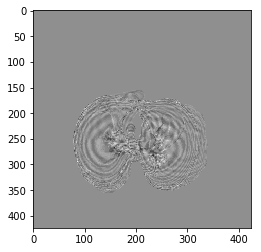

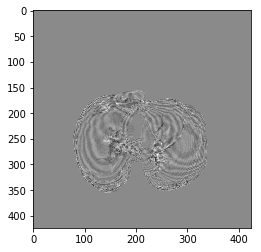

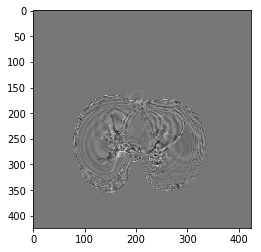

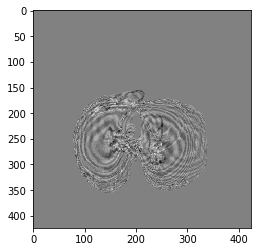

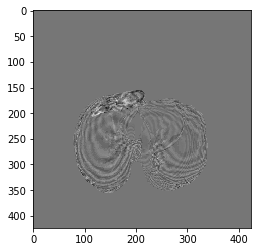

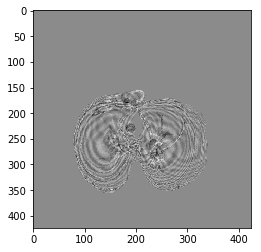

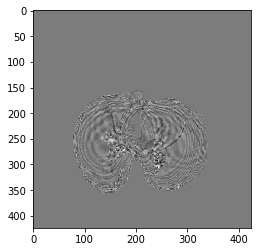

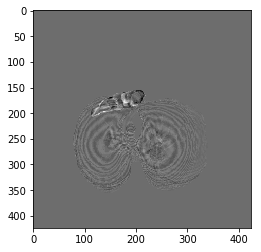

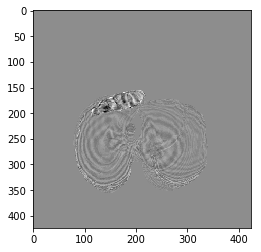

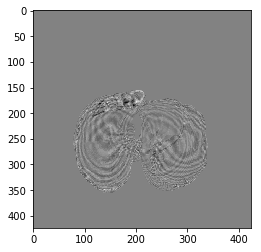

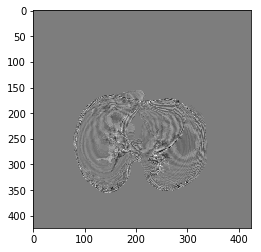

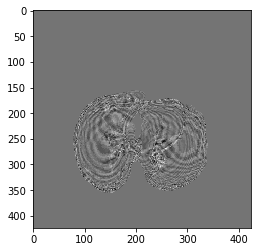

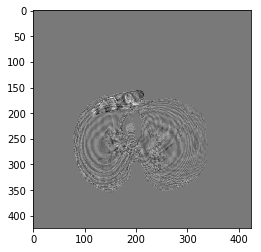

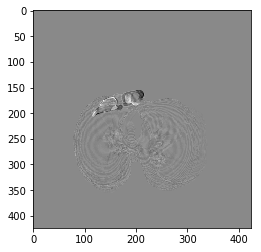

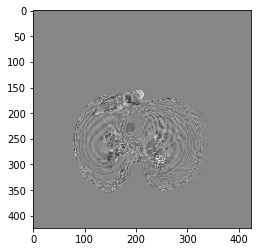

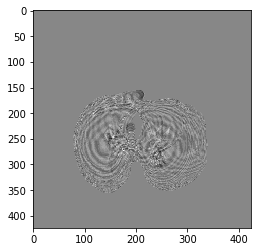

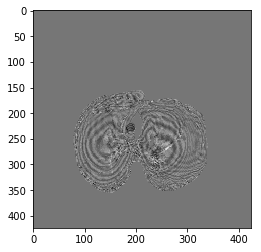

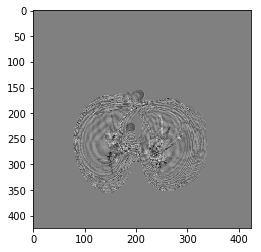

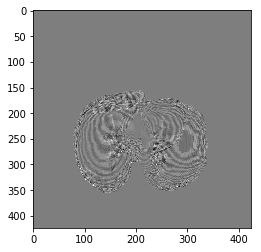

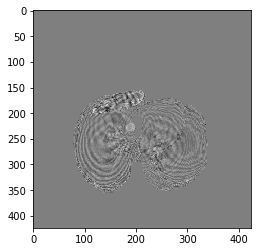

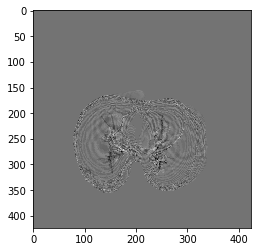

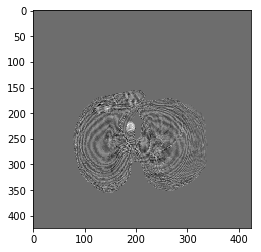

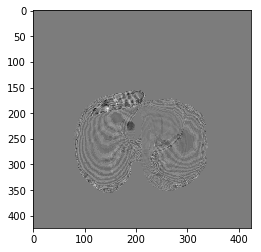

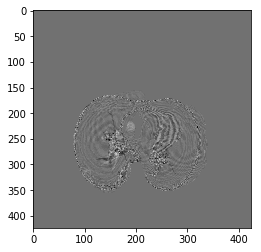

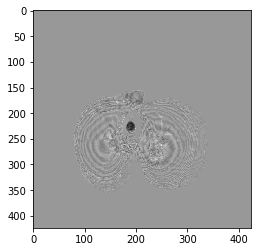

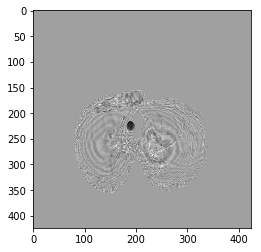

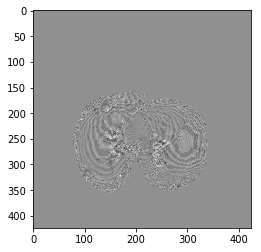

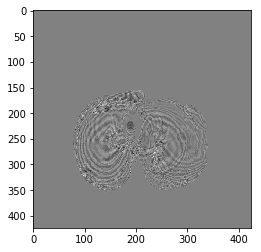

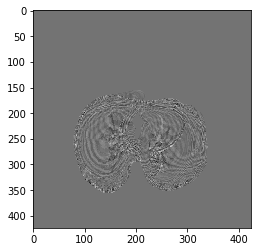

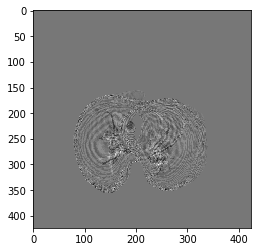

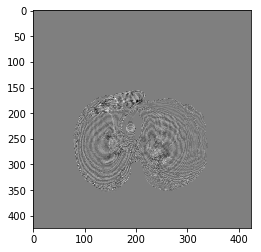

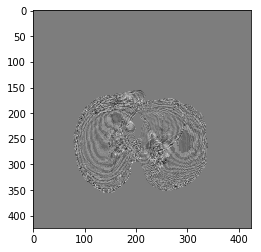

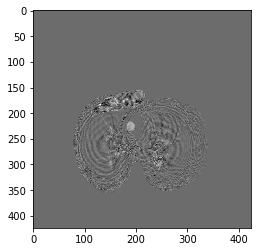

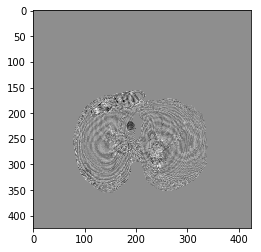

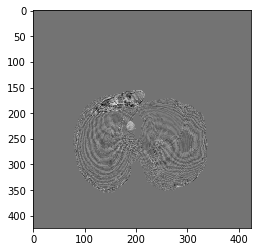

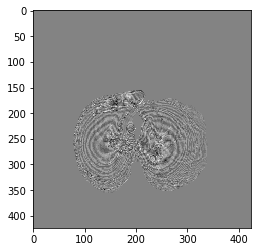

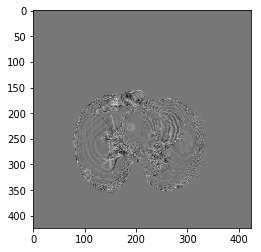

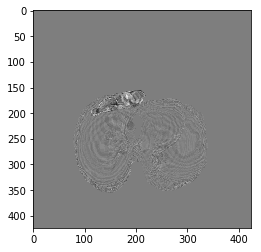

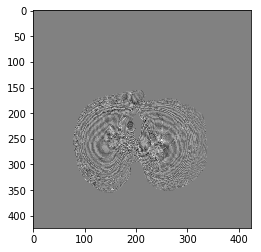

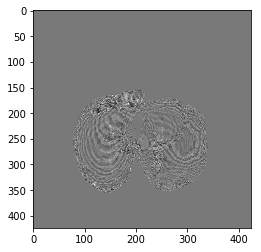

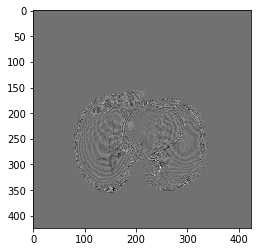

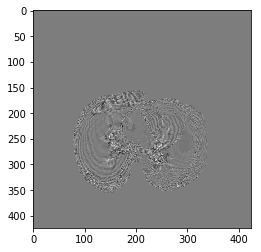

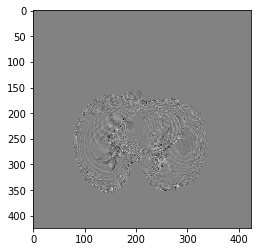

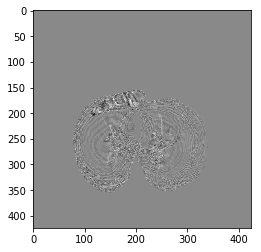

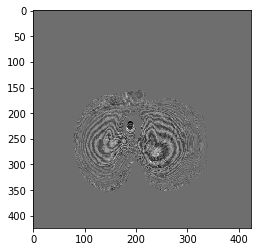

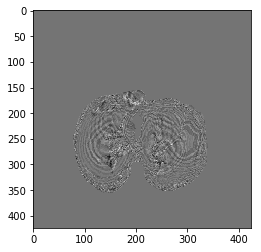

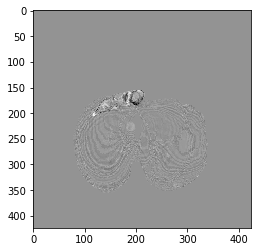

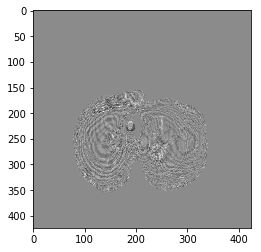

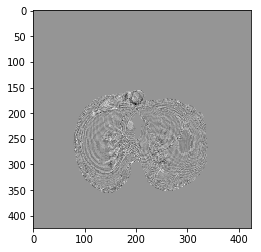

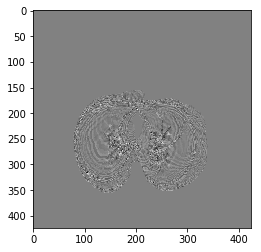

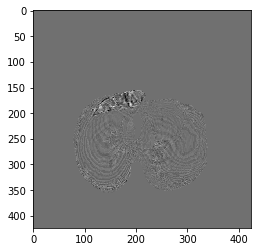

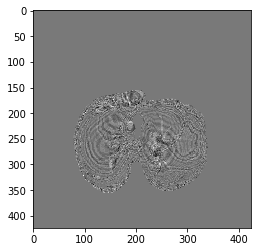

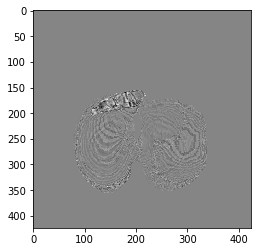

In [434]:
patient_num = 0
for i in range(0,n_components):
   plt.imshow(eigenvectors[patient_num][i].reshape(eigenvectors[patient_num].shape[1], 
                                                   eigenvectors[patient_num].shape[2]), cmap=plt.cm.gray)
   plt.show()

Analyzing the minimum number of eigenvectors where varience <= treshold:

In [436]:

for i in min_eigenvector:
    print(i)

34
34
34
35
33
33
31
34
34
34
31
36
33
25
31
31
34
34
31
31


Analyzing run time for n_components for sample size of 10

In [ ]:
n_components = 10
runs = 5
t0 = time()
runtimes = {}

for i in range(95, 105):
    for j in range(0, runs):
        t1 = time()
        w, x, y = PCA_transform(segmented_lungs_fill_flatten[j],n_components)

    print("---")
    print("total computation for n_components = " + str(i) + ", done in %0.3fs" % (time() - t0))
    runtimes[i] = (time() - t0)
    

---
total computation for n_components = 95, done in 14.345s
---
total computation for n_components = 96, done in 28.663s
---
total computation for n_components = 97, done in 43.051s
---
total computation for n_components = 98, done in 57.324s
---
total computation for n_components = 99, done in 71.548s
---
total computation for n_components = 100, done in 85.880s
---
total computation for n_components = 101, done in 100.165s
---
total computation for n_components = 102, done in 114.413s
---
total computation for n_components = 103, done in 128.650s


In [ ]:
plt.plot(list(runtimes.keys()), list(runtimes.values()), 'ro:')
plt.set_title('n_components vs runtime for n=5')
plt.show()